# Fidelity Prediction Of JanusQ-CT on Quantum Simualtor

**Author:** Congliang Lang \& Siwei Tan  

**Date:** 7/4/2024

Based on "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features (MICRO 2023][1]"

[1]: https://scholar.google.com/scholar_url?url=https://dl.acm.org/doi/abs/10.1145/3613424.3614274%3Fcasa_token%3DffjIB1hQ4ZwAAAAA:8MajDLrDOC74WoeMf7r7AoQ-koxCa4E1TNqQg3GSDz03xUX6XdE3toNTM-YdM_e4rKEusMceJ6BGJg&hl=zh-CN&sa=T&oi=gsb&ct=res&cd=0&d=11146218754516883150&ei=42YSZpPlFL6s6rQPtt6x6Ac&scisig=AFWwaeYaiu2hyx8HUJ_7Buf9Mwom

JanusQ enables an accurate fidelity prediction by considering the gate-dependent error (e.g. crosstalk and pulse distortion). Specifially, JanusQ uses a vectorization model to extract the topological and contextual information of circuits and intergate this information into the prediction. 

In this notebook, we introduce the fidelity prediction on the simulator. We also introduce the prediction on ther real world quantum device in the "[2-3.fidelity_prediction_realqc.ipynb][2]"

[2]: https://github.com/JanusQ/JanusQ/blob/main/janusq/examples/fidelity_prediction_18_qubit_realqc.ipynb


In [1]:
%matplotlib inline
import sys
sys.path.append('..')
import os
os.chdir("..")
import logging
logging.basicConfig(level=logging.WARN)
import ray
ray.init(log_to_driver=False)
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.baselines.fidelity_prediction.rb_prediction import RBModel
from janusq.simulator.gate_error_model import GateErrorModel

from janusq.analysis.vectorization import RandomwalkModel

from janusq.data_objects.random_circuit import random_circuits
from janusq.data_objects.backend import  LinearBackend

from janusq.simulator.noisy_simulator import NoisySimulator
import random

from janusq.tools.ray_func import map
import numpy as np


2024-04-25 06:06:06,486	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 66961408 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-04-25 06:06:07,650	INFO worker.py:1724 -- Started a local Ray instance.


## Constructing a vectorization model

JanusQ provides a simualtor that can model the gate-dependent error. To intialize this simulator, we first define a backend and construct a vectorization model.

In [2]:
# define a 5-qubit backend
n_qubits = 5
n_steps = 1
n_walks = 20
backend = LinearBackend(n_qubits, 1)

In [3]:
circuits = random_circuits(backend, n_circuits=200, n_gate_list=range(10, 110, 20), two_qubit_prob_list=[.4], reverse=True)
up_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend, circuits = circuits)

100%|██████████| 200/200 [00:01<00:00, 194.93it/s]


## Defining a simulator

The high gate-dependent errors in the simulator are represented by 1-step paths. The interaction is modeled by applying an RX operator with a random angle $[-\pi/20, \pi/20]$. In other words, the two gates of a 1-step path will be added with the RX operator if this path is injected with a noise.

In [4]:
# select 20 paths to represents sigificant interactions
all_paths = up_model.all_paths()
high_error_paths = random.choices(all_paths, k = 30)

# inject these paths into the error model of the simulator
error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = up_model

# construct the simualtor
simulator = NoisySimulator(backend=backend, gate_error_model = error_model)

We can use this simualtor to collect ground-truth fidelities.

In [5]:
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=True, multi_process=True)

100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


## Fidelity prediction

JanusQ-CT formulates the error $E$ of each gate as the dot-product between its vector $v_i$ and a weight vector $W$. The fidelity of the circuit $F_{circuit}$ is represented as the product of the gate fidelities (1 - gate error):
\begin{equation}
\begin{aligned}
    & E(v_i) = W^\top v_i, \\
    & F_{circuit} = \prod_{g_i \in G} (1- E(v_i)) \prod_{q \in Q} MF_{q}.
\end{aligned}
\end{equation}
The weight vector $W$ is trained by the stochastic gradient descent algorithm based on a fidelity dataset, consisting of the circuits and their ground-truth fidelities on the quantum devices.

In [6]:
# intialize the model and train weight vector W
fidelity_model = FidelityModel(up_model)
fidelity_model.train((circuits, ground_truth_fidelities), multi_process = True)

160it [00:00, 585592.18it/s]
40it [00:00, 342392.16it/s]


Epoch:     0 | Loss: 21.89293  | Dist: 21.89293 | Time: 2.828
Epoch:   100 | Loss: 6.19481  | Dist: 6.19481 | Time: 0.110
Epoch:   200 | Loss: 4.22357  | Dist: 4.22357 | Time: 0.109
Epoch:   300 | Loss: 3.73553  | Dist: 3.73553 | Time: 0.113
Epoch:   400 | Loss: 3.33909  | Dist: 3.33909 | Time: 0.119
Epoch:   500 | Loss: 3.08669  | Dist: 3.08669 | Time: 0.124
Epoch:   600 | Loss: 2.96513  | Dist: 2.96513 | Time: 0.135
Epoch:   700 | Loss: 2.89600  | Dist: 2.89600 | Time: 0.131
Epoch:   800 | Loss: 2.85214  | Dist: 2.85214 | Time: 0.121
Epoch:   900 | Loss: 2.82231  | Dist: 2.82231 | Time: 0.118
Epoch:  1000 | Loss: 2.80072  | Dist: 2.80072 | Time: 0.118
Epoch:  1100 | Loss: 2.79057  | Dist: 2.79057 | Time: 0.122
Epoch:  1200 | Loss: 2.78767  | Dist: 2.78767 | Time: 0.132
Epoch:  1300 | Loss: 2.78354  | Dist: 2.78354 | Time: 0.127
Epoch:  1400 | Loss: 2.77990  | Dist: 2.77990 | Time: 0.131
Epoch:  1500 | Loss: 2.77181  | Dist: 2.77181 | Time: 0.131


### Evaluate the Fidelity Prediction Model

JanusQ-CT is more accurate compared to previous method, such as the [random benchmarking][3]. We build a random benchmarking model to suggest that.

[3]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.77.012307

In [7]:
from janusq.baselines.fidelity_prediction.rb_prediction import RBModel
rb_model = RBModel(simulator, multi_process = True)

 75%|███████▌  | 3/4 [06:04<02:02, 122.64s/it]/usr/local/lib/python3.10/dist-packages/qiskit/ignis/verification/randomized_benchmarking/fitters.py:424: RuntimeWarning: invalid value encountered in scalar power
  alpha_guess = dy**(1/dcliff)
100%|██████████| 4/4 [08:18<00:00, 124.60s/it]


In [8]:
# generate fidelity dataset
benchmarking_circuits = random_circuits(backend, n_circuits=100, n_gate_list=range(10, 100, 10), two_qubit_prob_list=[.4], reverse=True)
benchmarking_fidelities = np.array(map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], benchmarking_circuits, show_progress=True, multi_process=True))

rb_fidelities = np.array(map(lambda circuit: rb_model.predict_circuit_fidelity(circuit), benchmarking_circuits))
janusct_fidelities = np.array(map(lambda circuit: fidelity_model.predict_circuit_fidelity(circuit), benchmarking_circuits))

100%|██████████| 11/11 [00:08<00:00,  1.22it/s]


0.6424096374317979 0.21508455338854915
1.1364964854324655 -0.126834083231093


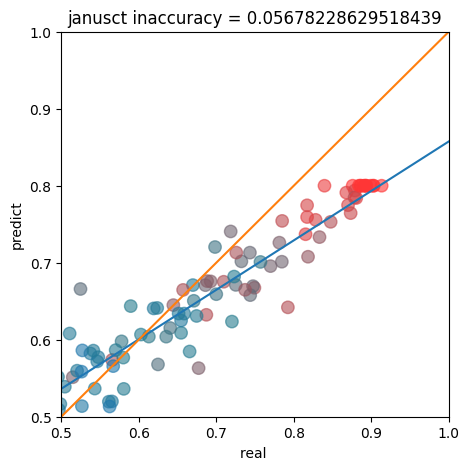

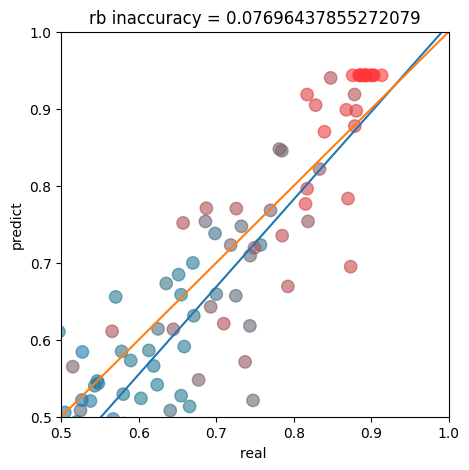

In [9]:

import matplotlib.pyplot as plt
from janusq.tools.plot import plot_scatter

durations = np.array([cir.duration for cir in benchmarking_circuits])

fig_quct, axes_quct = plot_scatter(benchmarking_fidelities, janusct_fidelities, durations, title = f"janusct inaccuracy = {np.abs(benchmarking_fidelities - janusct_fidelities).mean()}")
fig_rb, axes_rb = plot_scatter(benchmarking_fidelities, rb_fidelities, durations, title = f"rb inaccuracy = {np.abs(benchmarking_fidelities - rb_fidelities).mean()}")
